### Trying to create a model for county by county data for Wisconsin.
- Used the combined data from 2018-19 to 2022-23.
- For 2018-19 academic year, used the population and income data for the year 2018, and so on.
- Income and population data retrieved from the CAINC1 data file released by bea.gov.
- The county ('Shawano') present in Wisconsin AP data but not in CAINC1 file has been manually retrieved (population from census.gov and income from federal reserve in St. Louis).
- Used geopy to compute the average distance between counties and university. We take the five closest universities to compute the average distance.
### Also did naïve modelling with statsmodels
- Used 20% of the 350 datasets as testing data and the rest as training data.
- Percentage of 3 or above score (AKA pass rate) is used as the target variable.
- Per capita income, population and average distance to five closest R1R2, public, private (not for profit), stem and landgrant universities, as well as average enrollment in them are used as features.
- Full model includes all features.
- Uni metric model includes the ten university related metrics as features.
- Non-uni model includes per capita and population as features.
- The p-value of full model compared to uni metric model is extremely low. So, adding non-uni features (population and per capita income) to the uni-metric model improves the model.
- The p-value of full model compared to non-uni model, while still small, is comparatively larger. So, adding uni-metric features to the economic model (population and per capita income) does not improve the model as much.
- This is also illustrated by root mean squared error (rmse) computation on the tesitng data. The rmse with full model and non-uni model are very similar, whereas that with uni metric model is larger.
### Also did modelling with sklearn
- Considered the ordinary least squares (OLS) linear regression (with aforementioned three types of models), PCA-then-linear-regression model (with n-components = 0.95) and Ridge model.
- The PCA reduced the 12 features to 7 when set n-components=0.95.
- Did 5-fold cross validation, and compared the average root mean square errors (rmse) of the models.
- Ridge and full models had the lowest rmse, then followed by nonuni model and PCA model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import distance

In [2]:
carnegie = pd.read_csv('data/carnegie_with_location.csv')
wisconsin_2223 = pd.read_excel('data/Wisconsin/Wisconsin.xlsx',sheet_name='2022-23')
uscounties = pd.read_csv('data/uscounties.csv')

In [3]:
carnegie

,Unnamed: 0,unitid,name,city,stabbr,basic2000,basic2005,basic2010,basic2015,basic2018,...,hbcu,tribal,hsi,msi,womens,rooms,selindex,address,latitude,longitude
0,0,100654,Alabama A & M University,Normal,AL,16,18,18,18,18,...,1,0,0,1,0,3220,1.0,"4900 Meridian St N, Huntsville, AL 35811, USA",34.783841,-86.572224
1,1,100663,University of Alabama at Birmingham,Birmingham,AL,15,15,15,15,15,...,0,0,0,0,0,2882,2.0,"1720 University Blvd, Birmingham, AL 35294, USA",33.502086,-86.805159
2,2,100690,Amridge University,Montgomery,AL,51,24,24,20,20,...,0,0,0,0,0,0,1.0,"1200 Taylor Rd, Montgomery, AL 36117, USA",32.362671,-86.173926
3,3,100706,University of Alabama in Huntsville,Huntsville,AL,16,16,15,16,16,...,0,0,0,0,0,2200,3.0,"Shelby Center for Science and Technology, 301 ...",34.725161,-86.640471
4,4,100724,Alabama State University,Montgomery,AL,21,18,18,19,19,...,1,0,0,1,0,2079,1.0,"915 S Jackson St, Montgomery, AL 36104, USA",32.362976,-86.293980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3934,3934,496186,California Institute of Arts & Technology-Nati...,National City,CA,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,NaN,"National City, CA, USA",32.678109,-117.099197
3935,3935,999903,Inter-American Defense College,Washington,DC,-2,-2,-2,-2,32,...,0,0,0,0,0,0,0.0,"210 B St, Washington, DC 20319, USA",38.871030,-77.017851
3936,3936,999907,The Judge Advocate General's School,Charlottesville,VA,-2,-2,-2,-2,32,...,0,0,0,0,0,0,0.0,"Judge Advocate General's School, 600 Massie Rd...",38.054027,-78.507671
3937,3937,999909,United States Army War College,Carlisle,PA,-2,-2,-2,-2,32,...,0,0,0,0,0,0,0.0,"651 Wright Ave, Carlisle, PA 17013, USA",40.211661,-77.172440


In [4]:
uscounties.sample(n=10)

,county,county_ascii,county_full,county_fips,state_id,state_name,lat,lng,population
969,Harrisonburg,Harrisonburg,Harrisonburg City,51660,VA,Virginia,38.4362,-78.8735,51784
1005,Duplin,Duplin,Duplin County,37061,NC,North Carolina,34.9365,-77.9330,49312
3001,Schleicher,Schleicher,Schleicher County,48413,TX,Texas,30.8974,-100.5383,2474
1805,Bourbon,Bourbon,Bourbon County,21017,KY,Kentucky,38.2067,-84.2171,20228
2913,Fisher,Fisher,Fisher County,48151,TX,Texas,32.7428,-100.4022,3680
1383,Marshall,Marshall,Marshall County,21157,KY,Kentucky,36.8835,-88.3294,31706
3068,McCone,McCone,McCone County,30055,MT,Montana,47.6452,-105.7954,1746
532,Potter,Potter,Potter County,48375,TX,Texas,35.4013,-101.8939,117905
1215,Dallas,Dallas,Dallas County,1047,AL,Alabama,32.3260,-87.1065,38326
210,Somerset,Somerset,Somerset County,34035,NJ,New Jersey,40.5635,-74.6164,344978


In [5]:
wisconsin_counties = uscounties[uscounties['state_id'] == 'WI']

In [6]:
wisconsin_counties = wisconsin_counties.reset_index()

In [7]:
wisconsin_counties= wisconsin_counties[['county','lat','lng','population']]

In [8]:
wisconsin_counties

,county,lat,lng,population
0,Milwaukee,43.0072,-87.9669,933063
1,Dane,43.0673,-89.4181,559891
2,Waukesha,43.0182,-88.3045,407290
3,Brown,44.4525,-88.0037,268393
4,Racine,42.7475,-88.0613,197068
...,...,...,...,...
67,Forest,45.6673,-88.7704,9239
68,Pepin,44.5829,-92.0016,7363
69,Iron,46.2623,-90.2420,6136
70,Florence,45.8485,-88.3981,4574


In [9]:
coord1 = (carnegie.iloc[1].latitude,carnegie.iloc[1].longitude)
coord2 = (wisconsin_counties.iloc[1].lat,wisconsin_counties.iloc[1].lng)

In [10]:
distance(coord1,coord2).miles

674.7673624288187

In [11]:
wisconsin_2223

,Unnamed: 0,COUNTY,STUDENTS_TESTED,EXAM_COUNT,EXAMS_3_OR_ABOVE,PERCENT_3_OR_ABOVE
0,0,Adams,42,79,22,27.848101
1,1,Ashland,25,48,21,43.750000
2,2,Barron,115,178,93,52.247191
3,3,Bayfield,22,34,23,67.647059
4,4,Brown,1875,2903,2066,71.167757
...,...,...,...,...,...,...
64,64,Waukesha,6439,11372,8537,75.070348
65,65,Waupaca,334,460,243,52.826087
66,66,Waushara,60,90,38,42.222222
67,67,Winnebago,840,1122,780,69.518717


In [12]:
wisconsin_2223[wisconsin_2223['COUNTY'].isin(wisconsin_counties['county'].values) == False]

,Unnamed: 0,COUNTY,STUDENTS_TESTED,EXAM_COUNT,EXAMS_3_OR_ABOVE,PERCENT_3_OR_ABOVE
52,52,Saint Croix,1110,1675,1125,67.164179


In [13]:
wisconsin_counties.iloc[10:30]  #Saint Croix is given as St. Croix in "wisconsin_counties" dataframe.

,county,lat,lng,population
10,Washington,43.3685,-88.2307,136842
11,La Crosse,43.9066,-91.1152,120216
12,Sheboygan,43.7212,-87.9454,117741
13,Eau Claire,44.7268,-91.2860,105697
14,Walworth,42.6685,-88.5419,105127
15,Fond du Lac,43.7536,-88.4883,104027
16,St. Croix,45.0340,-92.4526,93752
17,Ozaukee,43.3840,-87.9509,91745
18,Dodge,43.4163,-88.7075,89032
19,Jefferson,43.0208,-88.7759,85932


In [14]:
wisconsin_2223=wisconsin_2223.replace(to_replace='Saint Croix',value='St. Croix') # Replace 'Saint Croix' by 'St. Croix

In [15]:
carnegie[carnegie['basic2021'].isin([15,16])]

,Unnamed: 0,unitid,name,city,stabbr,basic2000,basic2005,basic2010,basic2015,basic2018,...,hbcu,tribal,hsi,msi,womens,rooms,selindex,address,latitude,longitude
1,1,100663,University of Alabama at Birmingham,Birmingham,AL,15,15,15,15,15,...,0,0,0,0,0,2882,2.0,"1720 University Blvd, Birmingham, AL 35294, USA",33.502086,-86.805159
3,3,100706,University of Alabama in Huntsville,Huntsville,AL,16,16,15,16,16,...,0,0,0,0,0,2200,3.0,"Shelby Center for Science and Technology, 301 ...",34.725161,-86.640471
5,5,100751,The University of Alabama,Tuscaloosa,AL,15,16,16,16,15,...,0,0,0,0,0,8443,2.0,"Tuscaloosa, AL 35487, USA",33.211438,-87.540100
9,9,100858,Auburn University,Auburn,AL,15,16,16,16,15,...,0,0,0,0,0,4823,3.0,"Auburn, AL 36849, USA",32.598055,-85.494267
43,43,102094,University of South Alabama,Mobile,AL,16,18,18,16,16,...,0,0,0,0,0,3217,2.0,"307 N University Blvd, Mobile, AL 36688, USA",30.695941,-88.184236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417,3417,445188,University of California-Merced,Merced,CA,-2,-2,-2,16,16,...,0,0,0,0,0,4016,1.0,"5200 Lake Rd, Merced, CA 95343, USA",37.364703,-120.424094
3717,3717,482149,Augusta University,Augusta,GA,21,19,19,16,17,...,0,0,0,0,0,1228,2.0,"1120 15th St, Augusta, GA 30912, USA",33.470909,-81.989885
3744,3744,483124,Arizona State University Digital Immersion,Scottsdale,AZ,-2,-2,-2,17,16,...,0,0,0,0,0,0,0.0,"1151 S Forest Ave, Tempe, AZ, USA",33.422998,-111.927831
3793,3793,486840,Kennesaw State University,Kennesaw,GA,21,18,18,17,16,...,0,0,0,0,0,5116,2.0,"Kennesaw, GA, USA",34.023434,-84.615490


### First, we naively use the closest five universities in the given categories, and the average distance to them as features.

In [16]:
carnegie_full = pd.read_excel('data/CCIHE2021-PublicData.xlsx',sheet_name='Data')
carnegie_full

,unitid,name,city,stabbr,basic2000,basic2005,basic2010,basic2015,basic2018,basic2021,...,satv25,satm25,satcmb25,actcmp25,satacteq25,actfinal,appsf20,admitsf20,pctadmitf20,selindex
0,100654,Alabama A & M University,Normal,AL,16,18,18,18,18,18,...,430.0,410.0,840.0,15.0,15.0,15.000000,9855.0,8835.0,0.896499,1.0
1,100663,University of Alabama at Birmingham,Birmingham,AL,15,15,15,15,15,15,...,560.0,530.0,1090.0,22.0,21.0,21.875310,10391.0,8375.0,0.805986,2.0
2,100690,Amridge University,Montgomery,AL,51,24,24,20,20,20,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0
3,100706,University of Alabama in Huntsville,Huntsville,AL,16,16,15,16,16,15,...,590.0,580.0,1170.0,24.0,24.0,24.000000,5793.0,4467.0,0.771103,3.0
4,100724,Alabama State University,Montgomery,AL,21,18,18,19,19,17,...,438.0,406.0,840.0,14.0,15.0,14.298675,7027.0,6948.0,0.988758,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3934,496186,California Institute of Arts & Technology-Nati...,National City,CA,-2,-2,-2,-2,-2,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3935,999903,Inter-American Defense College,Washington,DC,-2,-2,-2,-2,32,32,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3936,999907,The Judge Advocate General's School,Charlottesville,VA,-2,-2,-2,-2,32,32,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3937,999909,United States Army War College,Carlisle,PA,-2,-2,-2,-2,32,32,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [17]:
carnegie['stem_rsd'] = carnegie_full['stem_rsd']
carnegie['anenr1920'] = carnegie_full['anenr1920']

In [18]:
def closest_five(carnegie_univ_data,lat,long):

    # carnegie_univ_data is meant to be sublist/subdataframe of carnegie dataset (with location)
    # lat is meant to be the latitude of the location (usually county)
    # long is meant to be the longitude of the location
    # Returns the average distance to the five closest universities from the supplied list.

    univ_distance = {'unitid':[],'distance':[]}
    for i in carnegie_univ_data.index:
        univ_distance['unitid']=univ_distance['unitid']+[carnegie_univ_data.unitid[i]]
        univ_distance['distance']=univ_distance['distance']+[distance((lat,long),(carnegie_univ_data.latitude[i],carnegie_univ_data.longitude[i])).km]
    univ_distance = pd.DataFrame(univ_distance)
    closest_five = univ_distance.sort_values(by = 'distance')[:5]
    return np.mean(closest_five['distance'].values)

carnegie_r1r2 = carnegie[carnegie['basic2021'].isin([15,16])]
closest_five(carnegie_r1r2,40.902771, -73.133850)  # This is the coordinates of Stony Brook.


44.58800478079978

In [19]:
wisconsin_counties['closest_five_r1r2_avg'] = wisconsin_counties.apply(lambda x: closest_five(carnegie_r1r2,x.lat, x.lng), axis=1)

In [20]:
carnegie_public = carnegie[carnegie['control'] == 1]
wisconsin_counties['closest_five_public_avg'] = wisconsin_counties.apply(lambda x: closest_five(carnegie_public,x.lat, x.lng), axis=1)

In [21]:
carnegie_private_notprofit = carnegie[carnegie['control'] == 2]
wisconsin_counties['closest_five_private_nfp_avg'] = wisconsin_counties.apply(lambda x: closest_five(carnegie_private_notprofit,x.lat, x.lng), axis=1)

In [22]:
carnegie_landgrnt = carnegie[carnegie['landgrnt'] == 1]
wisconsin_counties['closest_five_landgrnt_avg'] = wisconsin_counties.apply(lambda x: closest_five(carnegie_landgrnt,x.lat, x.lng), axis=1)

In [23]:
carnegie

,Unnamed: 0,unitid,name,city,stabbr,basic2000,basic2005,basic2010,basic2015,basic2018,...,hsi,msi,womens,rooms,selindex,address,latitude,longitude,stem_rsd,anenr1920
0,0,100654,Alabama A & M University,Normal,AL,16,18,18,18,18,...,0,1,0,3220,1.0,"4900 Meridian St N, Huntsville, AL 35811, USA",34.783841,-86.572224,NaN,6560
1,1,100663,University of Alabama at Birmingham,Birmingham,AL,15,15,15,15,15,...,0,0,0,2882,2.0,"1720 University Blvd, Birmingham, AL 35294, USA",33.502086,-86.805159,99.0,25843
2,2,100690,Amridge University,Montgomery,AL,51,24,24,20,20,...,0,0,0,0,1.0,"1200 Taylor Rd, Montgomery, AL 36117, USA",32.362671,-86.173926,NaN,1079
3,3,100706,University of Alabama in Huntsville,Huntsville,AL,16,16,15,16,16,...,0,0,0,2200,3.0,"Shelby Center for Science and Technology, 301 ...",34.725161,-86.640471,50.0,11312
4,4,100724,Alabama State University,Montgomery,AL,21,18,18,19,19,...,0,1,0,2079,1.0,"915 S Jackson St, Montgomery, AL 36104, USA",32.362976,-86.293980,NaN,4640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3934,3934,496186,California Institute of Arts & Technology-Nati...,National City,CA,-2,-2,-2,-2,-2,...,0,0,0,0,NaN,"National City, CA, USA",32.678109,-117.099197,NaN,383
3935,3935,999903,Inter-American Defense College,Washington,DC,-2,-2,-2,-2,32,...,0,0,0,0,0.0,"210 B St, Washington, DC 20319, USA",38.871030,-77.017851,NaN,0
3936,3936,999907,The Judge Advocate General's School,Charlottesville,VA,-2,-2,-2,-2,32,...,0,0,0,0,0.0,"Judge Advocate General's School, 600 Massie Rd...",38.054027,-78.507671,NaN,0
3937,3937,999909,United States Army War College,Carlisle,PA,-2,-2,-2,-2,32,...,0,0,0,0,0.0,"651 Wright Ave, Carlisle, PA 17013, USA",40.211661,-77.172440,NaN,0


In [24]:
carnegie_stem = carnegie[carnegie['stem_rsd'] > 0] # We define STEM institute to be the one offering at least one STEM research/scholarship doctoral degrees.
wisconsin_counties['closest_five_stem_avg'] = wisconsin_counties.apply(lambda x: closest_five(carnegie_stem,x.lat, x.lng), axis=1)

In [25]:
def closest_five_enrollment(carnegie_univ_data,lat,long):

    # carnegie_univ_data is meant to be sublist/subdataframe of carnegie dataset (with location and anenr1920)
    # lat is meant to be the latitude of the location (usually county)
    # long is meant to be the longitude of the location
    # Returns the average annual enrollment of the five closest universities from the supplied list.

    univ_enrollment = {'unitid':[],'distance':[],'enrollment':[]}
    for i in carnegie_univ_data.index:
        univ_enrollment['unitid']=univ_enrollment['unitid']+[carnegie_univ_data.unitid[i]]
        univ_enrollment['distance']=univ_enrollment['distance']+[distance((lat,long),(carnegie_univ_data.latitude[i],carnegie_univ_data.longitude[i])).km]
        univ_enrollment['enrollment'] = univ_enrollment['enrollment'] + [carnegie_univ_data['anenr1920'][i]]
    univ_enrollment = pd.DataFrame(univ_enrollment)
    closest_five = univ_enrollment.sort_values(by = 'distance')[:5]
    return np.mean(closest_five['enrollment'].values)
carnegie_r1r2 = carnegie[carnegie['basic2021'].isin([15,16])]
closest_five_enrollment(carnegie_r1r2,40.902771, -73.133850)  # This is the coordinates of Stony Brook.

21050.8

In [26]:
def closest_five_rooms(carnegie_univ_data,lat,long):
        # carnegie_univ_data is meant to be sublist/subdataframe of carnegie dataset (with location and anenr1920)
    # lat is meant to be the latitude of the location (usually county)
    # long is meant to be the longitude of the location
    # Returns the average dorm rooms of the five closest universities from the supplied list.

    univ_enrollment = {'unitid':[],'distance':[],'rooms':[]}
    for i in carnegie_univ_data.index:
        univ_enrollment['unitid']=univ_enrollment['unitid']+[carnegie_univ_data.unitid[i]]
        univ_enrollment['distance']=univ_enrollment['distance']+[distance((lat,long),(carnegie_univ_data.latitude[i],carnegie_univ_data.longitude[i])).km]
        univ_enrollment['rooms'] = univ_enrollment['rooms'] + [carnegie_univ_data['rooms'][i]]
    univ_enrollment = pd.DataFrame(univ_enrollment)
    closest_five = univ_enrollment.sort_values(by = 'distance')[:5]
    return np.mean(closest_five['rooms'].values)
carnegie_r1r2 = carnegie[carnegie['basic2021'].isin([15,16])]
closest_five_rooms(carnegie_r1r2,40.902771, -73.133850)  # This is the coordinates of Stony Brook.

4800.2

In [27]:
wisconsin_counties['closest_five_avg_enrollment_r1r2'] = wisconsin_counties.apply(lambda x: closest_five_enrollment(carnegie_r1r2,x.lat, x.lng), axis=1)
wisconsin_counties['closest_five_avg_enrollment_public'] = wisconsin_counties.apply(lambda x: closest_five_enrollment(carnegie_public,x.lat, x.lng), axis=1)
wisconsin_counties['closest_five_avg_enrollment_private_nfp'] = wisconsin_counties.apply(lambda x: closest_five_enrollment(carnegie_private_notprofit,x.lat, x.lng), axis=1)
wisconsin_counties['closest_five_avg_enrollment_landgrnt'] = wisconsin_counties.apply(lambda x: closest_five_enrollment(carnegie_landgrnt,x.lat, x.lng), axis=1)
wisconsin_counties['closest_five_avg_enrollment_stem'] = wisconsin_counties.apply(lambda x: closest_five_enrollment(carnegie_stem,x.lat, x.lng), axis=1)

In [28]:
wisconsin_counties['closest_five_avg_dormrooms_r1r2'] = wisconsin_counties.apply(lambda x: closest_five_rooms(carnegie_r1r2,x.lat, x.lng), axis=1)
wisconsin_counties['closest_five_avg_dormrooms_public'] = wisconsin_counties.apply(lambda x: closest_five_rooms(carnegie_public,x.lat, x.lng), axis=1)
wisconsin_counties['closest_five_avg_dormrooms_private_nfp'] = wisconsin_counties.apply(lambda x: closest_five_rooms(carnegie_private_notprofit,x.lat, x.lng), axis=1)
wisconsin_counties['closest_five_avg_dormrooms_landgrnt'] = wisconsin_counties.apply(lambda x: closest_five_rooms(carnegie_landgrnt,x.lat, x.lng), axis=1)
wisconsin_counties['closest_five_avg_dormrooms_stem'] = wisconsin_counties.apply(lambda x: closest_five_rooms(carnegie_stem,x.lat, x.lng), axis=1)

In [29]:
wisconsin_counties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   county                                   72 non-null     object 
 1   lat                                      72 non-null     float64
 2   lng                                      72 non-null     float64
 3   population                               72 non-null     int64  
 4   closest_five_r1r2_avg                    72 non-null     float64
 5   closest_five_public_avg                  72 non-null     float64
 6   closest_five_private_nfp_avg             72 non-null     float64
 7   closest_five_landgrnt_avg                72 non-null     float64
 8   closest_five_stem_avg                    72 non-null     float64
 9   closest_five_avg_enrollment_r1r2         72 non-null     float64
 10  closest_five_avg_enrollment_public       72 non-null

In [30]:
import data_loaders

In [31]:
incomes = data_loaders.gimmeCountyIncomes()
incomes = incomes[incomes['State_Abbreviation']=='WI']
incomes = pd.concat([pd.DataFrame([['Shawano','WI',42033,43883,46611,50004,50444]], columns=incomes.columns), incomes], ignore_index=True)


In [32]:
incomes

,County,State_Abbreviation,2018,2019,2020,2021,2022
0,Shawano,WI,42033,43883,46611,50004,50444
1,Adams,WI,39048,41159,43993,46112,44696
2,Ashland,WI,38879,40644,43573,46557,46014
3,Barron,WI,47650,49537,54519,56928,58029
4,Bayfield,WI,46098,47552,49990,53818,52963
...,...,...,...,...,...,...,...
68,Waukesha,WI,71073,73569,76931,84113,87582
69,Waupaca,WI,44466,46260,49255,53368,54632
70,Waushara,WI,40346,41135,43781,46976,46697
71,Winnebago,WI,47336,48651,51855,56253,56878


In [33]:
wisconsin_2223[wisconsin_2223['COUNTY'].isin(incomes['County'].values) == False]

,Unnamed: 0,COUNTY,STUDENTS_TESTED,EXAM_COUNT,EXAMS_3_OR_ABOVE,PERCENT_3_OR_ABOVE
52,52,St. Croix,1110,1675,1125,67.164179


In [34]:
population = data_loaders.gimmeCountyPopulation()
population=population[population['State_Abbreviation']=='WI']
population = pd.concat([pd.DataFrame([['Shawano','WI',40725,40794,40873,40812,40886]], columns=population.columns), population], ignore_index=True)
population

,County,State_Abbreviation,2018,2019,2020,2021,2022
0,Shawano,WI,40725,40794,40873,40812,40886
1,Adams,WI,20533,20431,20675,20795,21226
2,Ashland,WI,16013,16021,16018,16054,16039
3,Barron,WI,46385,46645,46714,46746,46843
4,Bayfield,WI,15872,16062,16233,16304,16608
...,...,...,...,...,...,...,...
68,Waukesha,WI,403616,405563,407467,409080,410434
69,Waupaca,WI,51917,51830,51791,51992,51488
70,Waushara,WI,24401,24563,24549,24797,24999
71,Winnebago,WI,170879,171875,171800,170554,170718


In [35]:
wisconsin_data = {'county':[],'year':[],'population':[],'per_capita_income':[]}
years = ['2018','2019','2020','2021','2022']
for county in incomes['County'].values:
    for year in years:
        wisconsin_data['county'] = wisconsin_data['county']+[county]
        wisconsin_data['year'] = wisconsin_data['year']+[year]
        wisconsin_data['population'] = wisconsin_data['population']+[int(population[population['County'] == county][year].values[0])]
        wisconsin_data['per_capita_income']= wisconsin_data['per_capita_income']+[int(incomes[incomes['County'] == county][year].values[0])]

In [36]:
wisconsin_data = pd.DataFrame(wisconsin_data)
wisconsin_data

,county,year,population,per_capita_income
0,Shawano,2018,40725,42033
1,Shawano,2019,40794,43883
2,Shawano,2020,40873,46611
3,Shawano,2021,40812,50004
4,Shawano,2022,40886,50444
...,...,...,...,...
360,Wood,2018,74085,45262
361,Wood,2019,74205,47142
362,Wood,2020,74197,49588
363,Wood,2021,74085,52678


In [37]:
int(population[population['County'] == 'Adams']['2018'].values[0])

20533

In [38]:
wisconsin_ap = pd.read_csv('data/Wisconsin/Wisconsin_combined.csv')

In [39]:
wisconsin_ap

,COUNTY,STUDENTS_TESTED,EXAM_COUNT,EXAMS_3_OR_ABOVE,PERCENT_3_OR_ABOVE,Year
0,Adams,45,76,22,28.947368,2018-19
1,Ashland,30,40,25,62.500000,2018-19
2,Barron,132,196,101,51.530612,2018-19
3,Bayfield,10,14,9,64.285714,2018-19
4,Brown,2207,3378,2356,69.745411,2018-19
...,...,...,...,...,...,...
344,Waukesha,6439,11372,8537,75.070348,2022-23
345,Waupaca,334,460,243,52.826087,2022-23
346,Waushara,60,90,38,42.222222,2022-23
347,Winnebago,840,1122,780,69.518717,2022-23


In [40]:
def clean_year(year):
    return year[:-3]
wisconsin_ap['Year']=wisconsin_ap['Year'].apply(clean_year)

In [41]:
list(wisconsin_ap[(wisconsin_ap['COUNTY'] == 'Adams') & (wisconsin_ap['Year'] == '2018')].COUNTY.values)

['Adams']

In [42]:
wisconsin_counties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   county                                   72 non-null     object 
 1   lat                                      72 non-null     float64
 2   lng                                      72 non-null     float64
 3   population                               72 non-null     int64  
 4   closest_five_r1r2_avg                    72 non-null     float64
 5   closest_five_public_avg                  72 non-null     float64
 6   closest_five_private_nfp_avg             72 non-null     float64
 7   closest_five_landgrnt_avg                72 non-null     float64
 8   closest_five_stem_avg                    72 non-null     float64
 9   closest_five_avg_enrollment_r1r2         72 non-null     float64
 10  closest_five_avg_enrollment_public       72 non-null

In [43]:
wisconsin_ap=wisconsin_ap.replace(to_replace='Saint Croix',value='St. Croix')
wisconsin_data=wisconsin_data.replace(to_replace='Saint Croix',value='St. Croix')
n=[]
for i in wisconsin_ap.index:
    county = wisconsin_ap.iloc[i].COUNTY
    year = wisconsin_ap.iloc[i].Year
    if list(wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_r1r2_avg.values) == []:
        n=n+[i]
print(n)

[]


In [44]:
list(wisconsin_counties.columns)

['county',
 'lat',
 'lng',
 'population',
 'closest_five_r1r2_avg',
 'closest_five_public_avg',
 'closest_five_private_nfp_avg',
 'closest_five_landgrnt_avg',
 'closest_five_stem_avg',
 'closest_five_avg_enrollment_r1r2',
 'closest_five_avg_enrollment_public',
 'closest_five_avg_enrollment_private_nfp',
 'closest_five_avg_enrollment_landgrnt',
 'closest_five_avg_enrollment_stem',
 'closest_five_avg_dormrooms_r1r2',
 'closest_five_avg_dormrooms_public',
 'closest_five_avg_dormrooms_private_nfp',
 'closest_five_avg_dormrooms_landgrnt',
 'closest_five_avg_dormrooms_stem']

In [45]:
years = ['2018','2019','2020','2021','2022']
lat = []
long = []
pop = []
pci = []
r1r2 = []
public = []
private_notprofit = []
landgrnt  = []
stem  = []
enrollment_r1r2 = []
enrollment_public = []
enrollment_private_nfp = []
enrollment_landgrnt = []
enrollment_stem = []
rooms_r1r2 = []
rooms_public = []
rooms_private_nfp = []
rooms_landgrant = []
rooms_stem = []


for i in wisconsin_ap.index:
    county = wisconsin_ap.iloc[i].COUNTY
    year = wisconsin_ap.iloc[i].Year
    lat = lat + [wisconsin_counties[(wisconsin_counties['county']==county)].lat.values[0]]
    long = long + [wisconsin_counties[(wisconsin_counties['county']==county)].lng.values[0]]
    pop = pop + [wisconsin_data[(wisconsin_data['county']==county) & (wisconsin_data['year'] == year)].population.values[0]]
    pci = pci + [wisconsin_data[(wisconsin_data['county']==county) & (wisconsin_data['year'] == year)].per_capita_income.values[0]]
    r1r2 = r1r2 + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_r1r2_avg.values[0]]
    public = public + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_public_avg.values[0]]
    private_notprofit = private_notprofit + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_private_nfp_avg.values[0]]
    landgrnt = landgrnt + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_landgrnt_avg.values[0]]
    stem = stem + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_stem_avg.values[0]]
    enrollment_r1r2 = enrollment_r1r2 + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_avg_enrollment_r1r2.values[0]]
    enrollment_public = enrollment_public + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_avg_enrollment_public.values[0]]
    enrollment_private_nfp = enrollment_private_nfp + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_avg_enrollment_private_nfp.values[0]]
    enrollment_landgrnt = enrollment_landgrnt + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_avg_enrollment_landgrnt.values[0]]
    enrollment_stem = enrollment_stem + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_avg_enrollment_stem.values[0]]
    rooms_r1r2 = rooms_r1r2 + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_avg_dormrooms_r1r2.values[0]]
    rooms_public = rooms_public + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_avg_dormrooms_public.values[0]]
    rooms_private_nfp = rooms_private_nfp + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_avg_dormrooms_private_nfp.values[0]]
    rooms_landgrant = rooms_landgrant + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_avg_dormrooms_landgrnt.values[0]]
    rooms_stem = rooms_stem + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_avg_dormrooms_stem.values[0]]

wisconsin_ap['Latitude'] = lat
wisconsin_ap['Longitude'] = long
wisconsin_ap['population'] = pop
wisconsin_ap['per_capita_income'] = pci
wisconsin_ap['closest_five_r1r2_avg'] = r1r2
wisconsin_ap['closest_five_public_avg'] = public
wisconsin_ap['closest_five_private_nfp_avg'] = private_notprofit
wisconsin_ap['closest_five_landgrnt_avg'] = landgrnt
wisconsin_ap['closest_five_stem_avg'] = stem
wisconsin_ap['closest_five_avg_enrollment_r1r2'] = enrollment_r1r2
wisconsin_ap['closest_five_avg_enrollment_public'] = enrollment_public
wisconsin_ap['closest_five_avg_enrollment_private_nfp'] = enrollment_private_nfp
wisconsin_ap['closest_five_avg_enrollment_landgrnt'] = enrollment_landgrnt
wisconsin_ap['closest_five_avg_enrollment_stem'] = enrollment_stem
wisconsin_ap['closest_five_avg_dormrooms_r1r2'] = rooms_r1r2
wisconsin_ap['closest_five_avg_dormrooms_public'] = rooms_public
wisconsin_ap['closest_five_avg_dormrooms_private_nfp'] = rooms_private_nfp
wisconsin_ap['closest_five_avg_dormrooms_landgrant'] = rooms_landgrant
wisconsin_ap['closest_five_avg_dormrooms_stem'] = rooms_stem

In [46]:
wisconsin_ap[wisconsin_ap['COUNTY'] == 'Waukesha']

,COUNTY,STUDENTS_TESTED,EXAM_COUNT,EXAMS_3_OR_ABOVE,PERCENT_3_OR_ABOVE,Year,Latitude,Longitude,population,per_capita_income,...,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
65,Waukesha,6567,11729,8535,72.768352,2018,43.0182,-88.3045,403616,71073,...,27215.0,15274.4,1273.2,30553.4,23576.2,5328.0,1596.6,517.0,8082.0,4383.4
135,Waukesha,6586,11506,8412,73.109682,2019,43.0182,-88.3045,405563,73569,...,27215.0,15274.4,1273.2,30553.4,23576.2,5328.0,1596.6,517.0,8082.0,4383.4
205,Waukesha,6409,11076,7838,70.765619,2020,43.0182,-88.3045,407467,76931,...,27215.0,15274.4,1273.2,30553.4,23576.2,5328.0,1596.6,517.0,8082.0,4383.4
275,Waukesha,6329,11029,8202,74.367576,2021,43.0182,-88.3045,409080,84113,...,27215.0,15274.4,1273.2,30553.4,23576.2,5328.0,1596.6,517.0,8082.0,4383.4
344,Waukesha,6439,11372,8537,75.070348,2022,43.0182,-88.3045,410434,87582,...,27215.0,15274.4,1273.2,30553.4,23576.2,5328.0,1596.6,517.0,8082.0,4383.4


In [47]:
wisconsin_data[wisconsin_data['county'] == 'Waukesha']

,county,year,population,per_capita_income
340,Waukesha,2018,403616,71073
341,Waukesha,2019,405563,73569
342,Waukesha,2020,407467,76931
343,Waukesha,2021,409080,84113
344,Waukesha,2022,410434,87582


In [48]:
#wisconsin_ap.to_csv('Wisconsin_closest_five_method.csv')

### "wisconsin_ap" is the dataframe that we will use for statistical analysis.

In [49]:
import seaborn as sns

In [50]:
from sklearn.model_selection import train_test_split
training, testing = train_test_split(wisconsin_ap, test_size = 0.2, random_state = 226)

In [ ]:
#training.to_csv('data/Wisconsin/train_test_split/training.csv')


In [ ]:
#testing.to_csv('data/Wisconsin/train_test_split/testing.csv')

In [51]:
wisconsin_ap.columns[8:]

Index(['population', 'per_capita_income', 'closest_five_r1r2_avg',
       'closest_five_public_avg', 'closest_five_private_nfp_avg',
       'closest_five_landgrnt_avg', 'closest_five_stem_avg',
       'closest_five_avg_enrollment_r1r2',
       'closest_five_avg_enrollment_public',
       'closest_five_avg_enrollment_private_nfp',
       'closest_five_avg_enrollment_landgrnt',
       'closest_five_avg_enrollment_stem', 'closest_five_avg_dormrooms_r1r2',
       'closest_five_avg_dormrooms_public',
       'closest_five_avg_dormrooms_private_nfp',
       'closest_five_avg_dormrooms_landgrant',
       'closest_five_avg_dormrooms_stem'],
      dtype='object')

### First, let's draw some plots for exploration.

In [52]:
features = list(wisconsin_ap.columns[8:])
'''for feature in features:
    sns.lmplot(data = training, y='PERCENT_3_OR_ABOVE',x=feature)'''

"for feature in features:\n    sns.lmplot(data = training, y='PERCENT_3_OR_ABOVE',x=feature)"

- Unsurprisingly, the pass rate is positively correlated to socio-economic features per capita income and population.
- However, the pass rate seems to be negatively correlated to four out of the five distance to university metrics (except the landgrant universities).
- The correlation with enrollment, however, seems almost non-existent.

### Let's do some statistical analysis with statsmodels

In [53]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [54]:
x_train = training.drop(['COUNTY','STUDENTS_TESTED','EXAM_COUNT','EXAMS_3_OR_ABOVE','PERCENT_3_OR_ABOVE','Year','Latitude','Longitude'],axis=1)
x_test = testing.drop(['COUNTY','STUDENTS_TESTED','EXAM_COUNT','EXAMS_3_OR_ABOVE','PERCENT_3_OR_ABOVE','Year','Latitude','Longitude'],axis=1)
y_train = training[['PERCENT_3_OR_ABOVE']]
y_test = testing[['PERCENT_3_OR_ABOVE']]
X_train = sm.add_constant(x_train)
X_test = sm.add_constant(x_test)
unimetric_train = X_train.drop(['population','per_capita_income'],axis=1)
unimetric_test = X_test.drop(['population','per_capita_income'],axis=1)
X_train

,const,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
124,1.0,65586,52266,165.657277,79.050762,87.107569,241.077779,150.841269,28789.0,18208.8,2322.8,29555.6,22189.6,5812.6,2876.2,659.4,5587.6,4480.6
31,1.0,16631,42307,149.777499,59.774503,49.414130,265.933725,147.383482,28789.0,16490.0,1105.8,40912.2,23072.4,5812.6,2271.8,580.6,8589.0,5085.2
93,1.0,23688,49996,155.105400,59.472726,68.600648,256.012403,151.749264,28789.0,16490.0,1801.8,29555.6,22189.6,5812.6,2271.8,514.8,5587.6,4480.6
113,1.0,90998,83681,100.211662,43.374257,29.321344,237.854721,76.702890,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
183,1.0,91613,86875,100.211662,43.374257,29.321344,237.854721,76.702890,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,1.0,46746,56928,315.001573,56.850040,104.645890,180.023262,265.872638,33726.6,8040.4,2396.0,13358.4,24446.6,7165.0,1452.2,718.8,1502.8,3910.4
204,1.0,136784,61808,99.992900,43.885707,34.165428,242.505515,76.110717,27215.0,13718.0,2207.4,30553.4,23576.2,5328.0,727.4,488.8,8082.0,4383.4
213,1.0,16304,53818,349.980358,73.937033,142.596656,176.494830,316.183281,32768.4,4791.8,1589.6,13358.4,27023.8,5750.4,733.6,470.4,1502.8,5023.0
138,1.0,171875,48651,171.045198,42.659306,44.717736,226.369238,148.475619,27064.0,12610.2,1996.4,9798.8,23576.2,5303.4,485.2,1057.8,1774.2,4383.4


In [55]:
full_model = sm.OLS(y_train,X_train).fit()
unimetric_model = sm.OLS(y_train,unimetric_train).fit()
nonuni_model = smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income + population', data=training).fit()
unidistance_model = smf.ols('PERCENT_3_OR_ABOVE ~ closest_five_r1r2_avg + closest_five_public_avg + closest_five_private_nfp_avg + closest_five_landgrnt_avg + closest_five_stem_avg', data = training).fit()
pci_model=smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income', data =training).fit()

In [56]:
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     PERCENT_3_OR_ABOVE   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     8.522
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           3.09e-17
Time:                        09:21:59   Log-Likelihood:                -1067.9
No. Observations:                 279   AIC:                             2172.
Df Residuals:                     261   BIC:                             2237.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                     -35.0648     29.892     -1.173      0.242     -93.925      23.795
population                               1.022e-05   7.01e-06      1.458      0.146   -3.58e-06     2.4e-05
per_capita_income                           0.0005   9.72e-05      4.885      0.000       0.000       0.001
closest_five_r1r2_avg                      -0.1544      0.160     -0.968      0.334      -0.469       0.160
closest_five_public_avg                    -0.2770      0.084     -3.302      0.001      -0.442      -0.112
closest_five_private_nfp_avg                0.0496      0.057      0.873      0.383      -0.062       0.162
closest_five_landgrnt_avg                   0.2282      0.112      2.041      0.042       0.008       0.448
closest_five_stem_avg                       0.1919      0.153      1.256      0.210      -0.109       0.493
closest_five_avg_enrollment_r1r2            0.0021      0.001      4.127      0.000       0.001       0.003
closest_five_avg_enrollment_public          0.0005      0.001      0.885      0.377      -0.001       0.002
closest_five_avg_enrollment_private_nfp     0.0010      0.002      0.661      0.509      -0.002       0.004
closest_five_avg_enrollment_landgrnt       -0.0006      0.000     -1.785      0.076      -0.001    6.34e-05
closest_five_avg_enrollment_stem           -0.0006      0.000     -1.166      0.245      -0.002       0.000
closest_five_avg_dormrooms_r1r2            -0.0015      0.003     -0.451      0.652      -0.008       0.005
closest_five_avg_dormrooms_public          -0.0061      0.003     -2.285      0.023      -0.011      -0.001
closest_five_avg_dormrooms_private_nfp     -0.0208      0.004     -4.839      0.000      -0.029      -0.012
closest_five_avg_dormrooms_landgrant        0.0006      0.001      0.396      0.693      -0.002       0.004
closest_five_avg_dormrooms_stem             0.0027      0.003      0.953      0.342      -0.003       0.008
==============================================================================
Omnibus:                       13.054   Durbin-Watson:                   2.141
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.129
Skew:                          -0.370   Prob(JB):                     0.000191
Kurtosis:                       3.962   Cond. No.                     7.68e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.68e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
f_test_nonuni = full_model.compare_f_test(nonuni_model)
f_test_unimetric = full_model.compare_f_test(unimetric_model)
f_test_unidistance = unimetric_model.compare_f_test(unidistance_model)
print("p-value of full compared to non-university metric model:", f_test_nonuni[1])
print("p-value of full compared to university metric model:", f_test_unimetric[1])
print("p-value of university metric compared to university distance model:", f_test_unidistance[1])

p-value of full compared to non-university metric model: 3.731663573638301e-09
p-value of full compared to university metric model: 2.2652849024398932e-06
p-value of university metric compared to university distance model: 5.445215210755048e-10


### All three p-values are small, which is probably indicative of the fact that the models are not as accurate as we would want.

In [58]:
predictions_full_model = full_model.predict(X_test)  # Compute the predictions using the full model on the testing data
predictions_nonuni_model = nonuni_model.predict(testing) # Compute the predictions using the nonuni model (purely socioeconomic) on the testing data
predictions_unimetric_model = unimetric_model.predict(unimetric_test) # Compute the predictions using the unimetric model (university metric) on the testing data

In [59]:
y_test

,PERCENT_3_OR_ABOVE
96,63.516260
207,43.956044
41,65.202703
312,62.000000
121,58.988764
...,...
236,60.890152
160,47.745902
80,59.398496
50,69.230769


In [60]:
from statsmodels.tools.eval_measures import rmse

rmse_full = rmse(testing['PERCENT_3_OR_ABOVE'], predictions_full_model)
print('root mean squared error with full model is: ',rmse_full)

root mean squared error with full model is:  9.220120392194335


In [61]:
rmse_nonuni = rmse(testing['PERCENT_3_OR_ABOVE'], predictions_nonuni_model)
print('root mean squared error with nonuni model is: ',rmse_nonuni)

root mean squared error with nonuni model is:  9.31961901160709


In [62]:
rmse_uni = rmse(testing['PERCENT_3_OR_ABOVE'], predictions_unimetric_model)
print('root mean squared error with uni model is: ',rmse_uni)

root mean squared error with uni model is:  10.440725686108122


# Next, we will use sklearn to create machine learning models
- The models will be named analogously to statsmodels, but without the underscore.

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [64]:
uni_features = list(wisconsin_ap.columns[10:])
nonuni_features = list(wisconsin_ap.columns[8:10])
features_wo_dormrooms = list(wisconsin_ap.columns[8:-5])
features_wo_dormrooms

['population',
 'per_capita_income',
 'closest_five_r1r2_avg',
 'closest_five_public_avg',
 'closest_five_private_nfp_avg',
 'closest_five_landgrnt_avg',
 'closest_five_stem_avg',
 'closest_five_avg_enrollment_r1r2',
 'closest_five_avg_enrollment_public',
 'closest_five_avg_enrollment_private_nfp',
 'closest_five_avg_enrollment_landgrnt',
 'closest_five_avg_enrollment_stem']

In [65]:
fullmodel = LinearRegression()
fullmodel.fit(training[features],training['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [66]:
unimodel = LinearRegression()
unimodel.fit(training[uni_features],training['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [67]:
nonunimodel = LinearRegression()
nonunimodel.fit(training[nonuni_features],training['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [68]:
wodormrooms_model = LinearRegression()
wodormrooms_model.fit(training[features_wo_dormrooms],training['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [69]:
fullmodel.intercept_

-35.06481606927472

In [70]:
fullmodel.coef_

array([ 1.02154169e-05,  4.74853413e-04, -1.54404005e-01, -2.77049576e-01,
        4.96136503e-02,  2.28154888e-01,  1.91871636e-01,  2.10550004e-03,
        4.95826700e-04,  1.03869552e-03, -6.13103290e-04, -5.61628410e-04,
       -1.47056614e-03, -6.10147098e-03, -2.08308442e-02,  5.86249747e-04,
        2.67840638e-03])

In [71]:
from sklearn.metrics import root_mean_squared_error

In [72]:
root_mean_squared_error(fullmodel.predict(testing[features]),testing['PERCENT_3_OR_ABOVE'])

9.220120392194293

In [73]:
root_mean_squared_error(unimodel.predict(testing[uni_features]),testing['PERCENT_3_OR_ABOVE'])

10.440725686108134

In [74]:
root_mean_squared_error(nonunimodel.predict(testing[nonuni_features]),testing['PERCENT_3_OR_ABOVE'])

9.319619011607092

In [75]:
root_mean_squared_error(wodormrooms_model.predict(testing[features_wo_dormrooms]),testing['PERCENT_3_OR_ABOVE'])

9.78342167491957

In [76]:
## import KFold and kNeighborsRegressor here
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor

In [77]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the mse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    wisconsin_train = training.iloc[train_index]
    
    ## cv holdout set
    wisconsin_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the "take the mean and call it a day" model
    baseline_pred = wisconsin_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(wisconsin_holdout))
    
    rmses[0, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(wisconsin_holdout[features]))
    
    
    ## Fit and get ho mse for nonuni model
    nonuni_lr = LinearRegression()
    
    nonuni_lr.fit(wisconsin_train[nonuni_features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[2, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], nonuni_lr.predict(wisconsin_holdout[nonuni_features]))
    
    ## Fit and get ho mse for uni model
    uni_lr = LinearRegression()

    uni_lr.fit(wisconsin_train[uni_features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], uni_lr.predict(wisconsin_holdout[uni_features]))

    i = i+1


In [78]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"nonuni model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"uni model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 13.8952139409969 and STD: 1.0814455082287104
fullmodel Avg. CV RMSE: 11.932550600514022 and STD: 0.5525042295596989
nonuni model Avg. CV RMSE: 12.7917917484458 and STD: 0.83153691794454
uni model Avg. CV RMSE: 12.480347156741235 and STD: 0.8005245009284898


### All three models have lower average RMSE than the baseline. The full model including all the features has the lowest average 5-Fold cross-validation RMSE.

### While nonunimodel performed better than uni model on testing data, it performed slightly worse on cross-validation. Probably, uni-model is over-fitting on the training data because of the presence of a lot of features.

### **Next, let's do some PCA**

In [79]:
scaler = StandardScaler()
training_scaled = scaler.fit_transform(training[features])
training_scaled.shape

(279, 17)

In [80]:
pca = PCA(0.95)
training_pca = pca.fit_transform(training_scaled)

In [81]:
training_pca.shape

(279, 9)

In [82]:
pca.explained_variance_ratio_

array([0.41194672, 0.20111255, 0.10427498, 0.07210831, 0.06168245,
       0.040438  , 0.03217378, 0.02520899, 0.01566555])

**PCA can reduce the number of features from 17 to 9, if we require n-components = 0.95**

### Comparing PCA model and Ridge model and the full model

In [83]:
pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('reg', LinearRegression())])
ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

In [84]:
pca_pipe.fit(training[features],training['PERCENT_3_OR_ABOVE'])
ridge_pipe.fit(training[features],training['PERCENT_3_OR_ABOVE'])

Pipeline(steps=[('scale', StandardScaler()), ('ridge', Ridge())])

In [85]:
ridge_test_preds = ridge_pipe.predict(testing[features])
pca_test_preds = pca_pipe.predict(testing[features])

In [86]:

ridge_test_rmse = root_mean_squared_error(testing['PERCENT_3_OR_ABOVE'], ridge_test_preds)
pca_test_rmse = root_mean_squared_error(testing['PERCENT_3_OR_ABOVE'], pca_test_preds)

In [87]:
print(f"Ridge Test RMSE: {ridge_test_rmse}")
print(f"PCA Test RMSE: {pca_test_rmse}")

Ridge Test RMSE: 9.257154816062448
PCA Test RMSE: 9.562130457987514


### Ridge model is almost as good as the full model. PCA (n-components = 0.95) is not that far behind.

In [88]:
from sklearn.metrics import mean_absolute_error

In [89]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    wisconsin_train = training.iloc[train_index]
    
    ## cv holdout set
    wisconsin_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = wisconsin_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(wisconsin_holdout))
    
    rmses[0, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(wisconsin_holdout[features]))
    
    
    ## Fit and get ho mse for PCA model
    pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('reg', LinearRegression())])
    
    pca_pipe.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[2, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], pca_pipe.predict(wisconsin_holdout[features]))
    
    ## Fit and get ho mse for Ridge model
    ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

    ridge_pipe.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], ridge_pipe.predict(wisconsin_holdout[features]))

    i = i+1


In [90]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"PCA model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Ridge model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 13.8952139409969 and STD: 1.0814455082287104
fullmodel Avg. CV RMSE: 11.932550600514022 and STD: 0.5525042295596989
PCA model Avg. CV RMSE: 12.69751393720681 and STD: 0.8066810024461896
Ridge model Avg. CV RMSE: 11.897170135820053 and STD: 0.599522389987669


**Ridge model performs the best on cross-validation, then closely followed very closely by full model.**

# Let's create models using XGBOOST

In [91]:
import xgboost as xgb
xgb.__version__

'2.1.2'

In [92]:
X_train = training[features]
X_test = testing[features]
y_train = training['PERCENT_3_OR_ABOVE']
y_test = testing['PERCENT_3_OR_ABOVE']

In [93]:
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [94]:


params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
n = 1000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)

[0]	train-rmse:11.04652	validation-rmse:9.24068
[10]	train-rmse:3.24861	validation-rmse:7.81770
[20]	train-rmse:1.81923	validation-rmse:8.45080
[30]	train-rmse:1.20598	validation-rmse:8.67432
[40]	train-rmse:0.81077	validation-rmse:8.76540
[50]	train-rmse:0.61229	validation-rmse:8.81940
[60]	train-rmse:0.41931	validation-rmse:8.85108
[70]	train-rmse:0.30323	validation-rmse:8.88470
[80]	train-rmse:0.21477	validation-rmse:8.89333
[90]	train-rmse:0.15630	validation-rmse:8.91170
[100]	train-rmse:0.10993	validation-rmse:8.91927
[102]	train-rmse:0.10124	validation-rmse:8.92145


**Some sample predictions**

In [96]:
# Example: New data to predict
X_new = training[features].head(3)  ## just use the old data as a quick example

# Create a DMatrix for the new data
dnew_reg = xgb.DMatrix(X_new, enable_categorical=True)

# Make predictions
y_pred_new = xgb_model.predict(dnew_reg)

print('Predictions for new percentage of AP outcomes that scores 3-5:')
print(y_pred_new)

Predictions for new percentage of AP outcomes that scores 3-5:
[58.63049  42.260983 59.32202 ]


### Cross validation

In [97]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=100
)

results.head()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,11.038179,0.302851,11.947252,1.524106
1,9.036346,0.260972,10.969807,1.479574
2,7.519773,0.292657,10.346317,1.426893
3,6.435489,0.310721,10.165606,1.327798


In [98]:
mean_train_rmse = results['train-rmse-mean'].iloc[-1]  # Final mean train RMSE
std_train_rmse = results['train-rmse-std'].iloc[-1]    # Final std dev train RMSE

mean_val_rmse = results['test-rmse-mean'].iloc[-1]     # Final mean validation RMSE
std_val_rmse = results['test-rmse-std'].iloc[-1]       # Final std dev validation RMSE

# Print results
print(f"Training RMSE: {mean_train_rmse:.4f} +/- {std_train_rmse:.4f}")
print(f"Validation RMSE: {mean_val_rmse:.4f} +/- {std_val_rmse:.4f}")

Training RMSE: 6.4355 +/- 0.3107
Validation RMSE: 10.1656 +/- 1.3278


### Predictions on the testing data

In [102]:
# Make predictions
dnew_reg = xgb.DMatrix(X_test, enable_categorical=True)
testing_preds = xgb_model.predict(dnew_reg)

print('Predictions for new percentage of AP outcomes that scores 3-5:')
print(testing_preds)

Predictions for new percentage of AP outcomes that scores 3-5:
[59.1016   43.6435   64.57273  63.47867  63.023506 25.770529 55.268543
 66.07399  33.46701  41.511627 60.0512   54.254276 65.85091  42.535904
 56.89352  55.62326  53.41391  40.72327  43.21706  74.20842  53.02358
 43.93302  78.36218  74.20842  40.80748  77.96174  68.93717  45.824783
 48.719017 59.31965  51.99972  56.813995 55.011623 59.08414  48.645905
 67.00532  63.828    58.094822 57.8015   55.4376   42.235058 57.62284
 61.93994  57.161877 63.61221  40.662117 55.73342  50.567165 75.0202
 34.36325  71.84536  60.407524 40.37437  58.40063  57.85933  42.537987
 65.980255 44.70259  56.89352  60.266926 43.25448  55.11148  54.084305
 56.47408  57.10703  56.756966 44.869442 54.127243 51.923386 45.702904]


In [103]:
root_mean_squared_error(testing_preds,y_test)

8.921472375409564

In [107]:
## "Take the average and call it a day" model on the testing data
average_pass_rate=np.mean(y_test)*np.ones(len(y_test))
root_mean_squared_error(average_pass_rate,y_test)

10.80474045823677

### Comparing RMSE's on testing data of various models:
- "Take average and call it a day" model: 10.80474045823677
- OLS full model (sklearn): 9.220120392194293
- Ridge model (sklearn): 9.257154816062448
- PCA(0.95) model (sklearn): 9.562130457987514
- Xgboost model with full features: 8.921472375409564

### As we can see, the xgboost model is the best, but sklearn's OLS linear regression and Ridge models are not very far behind.

# Let's use SHAP to explain our models.

In [109]:
import shap

### Shap explainer on Xgboost model:

In [110]:
#explainer = shap.Explainer(fullmodel,training[features])
#shap_values = explainer(training[features])
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

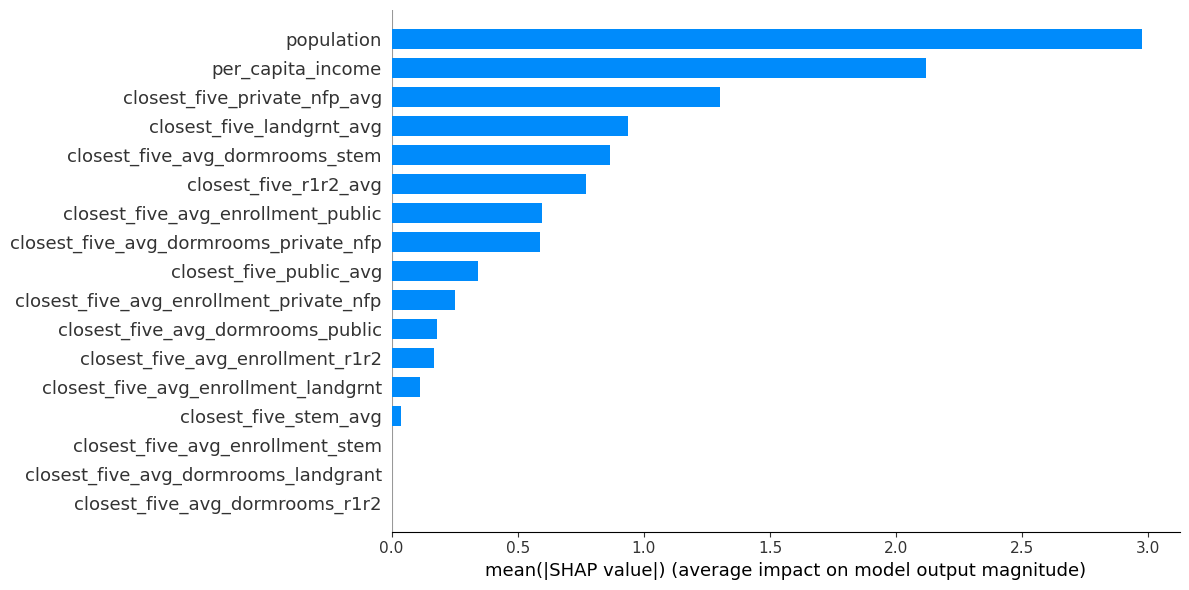

In [112]:
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
plt.show()
plt.close()

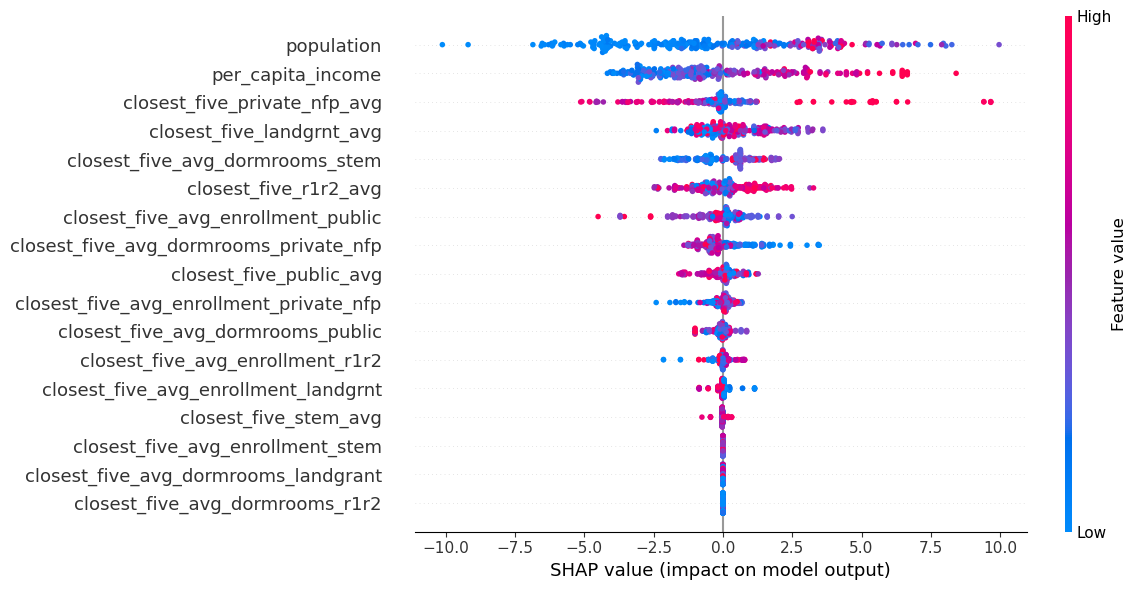

In [113]:
### the scatter plot
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.show()
plt.close()